In [5]:
# Importing packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import umap.umap_ as umap

In [ ]:
# loading dataset and handle a subset of it
path_2 = "datasets/diabetes_binary_health_indicators_BRFSS2015.csv"

df = pd.read_csv(path_2)

[Binary] After Undersampling: Counter({0.0: 60000, 1.0: 35346})
[Binary] After SMOTEENN: Counter({1.0: 36280, 0.0: 31487})
[Binary] After TomekLinks: Counter({1.0: 36268, 0.0: 31487})


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


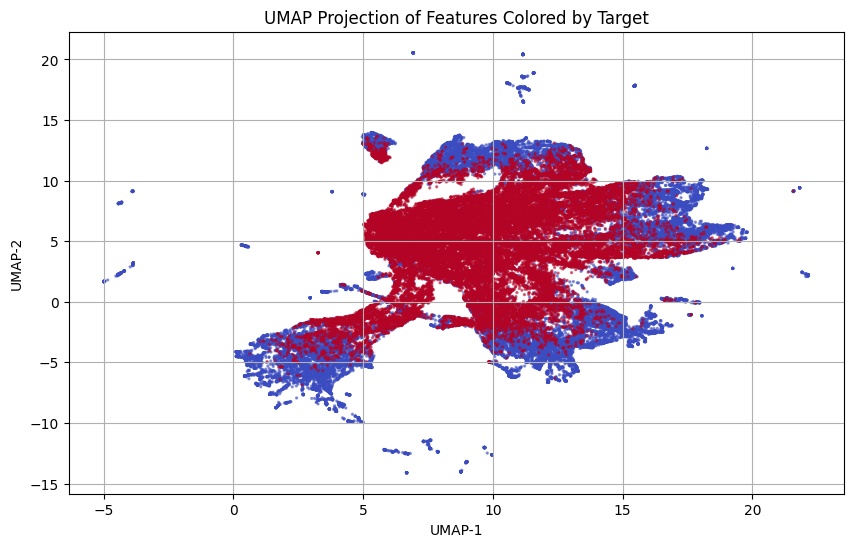

In [7]:
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

undersample2 = RandomUnderSampler(sampling_strategy={0.0: 60000}, random_state=17)
X_und, y_und = undersample2.fit_resample(X, y)

print("[Binary] After Undersampling:", Counter(y_und))

smote2 = SMOTEENN(random_state=42, sampling_strategy="auto", n_jobs=-1)
X_und, y_und = smote2.fit_resample(X_und, y_und)
print("[Binary] After SMOTEENN:", Counter(y_und))

tomek = TomekLinks()
X_und, y_und = tomek.fit_resample(X_und, y_und)
print("[Binary] After TomekLinks:", Counter(y_und))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_und)

pca = PCA(n_components=5) 
X_scaled = pca.fit_transform(X_scaled)

# Apply UMAP for 2D projection
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_und, cmap='coolwarm', s=2, alpha=0.5)
plt.title("UMAP Projection of Features Colored by Target")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

In [8]:
# Step 1: Load data and apply undersampling BEFORE the split
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

print("Before balancing:", Counter(y))

X_train_af, X_test_af, y_train_af, y_test_af = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=22)

# Undersample class 0 slightly
undersample = RandomUnderSampler(sampling_strategy={0.0: 20000}, random_state=17)
X_bal, y_bal = undersample.fit_resample(X, y)
print("After undersampling:", Counter(y_bal))

# Step 2: Train/test split (test set remains untouched)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# Step 3: Build pipeline with SMOTE applied only to training data
pipeline = Pipeline([
    #('smote', SMOTEENN(sampling_strategy="auto", random_state=42, n_jobs=-1)),
    ('tomek',  TomekLinks()),
    ('scaler', StandardScaler()),
    ('nystroem', Nystroem(kernel='rbf', gamma=0.1, n_components=1000, random_state=42)),
    ('clf', LinearSVC(C=1.0, class_weight='balanced', random_state=28))
])

# Step 4: Optional CV evaluation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
y_train_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv, n_jobs=-1)

print("\nCross-validated Training Report:")
print(classification_report(y_train, y_train_pred))

# Fit on full training set and evaluate on untouched test set with undersampling
pipeline.fit(X_train, y_train)
y_test_pred1 = pipeline.predict(X_test)

print("\nFinal Test Report with undersampling:")
print(classification_report(y_test, y_test_pred1))

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred1))

# Fit on full training set and evaluate on untouched test set without undersampling
y_test_pred_af = pipeline.predict(X_test_af)

print("\nFinal Test Report without undersampling:")
print(classification_report(y_test_af, y_test_pred_af))

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_af, y_test_pred_af))

Before balancing: Counter({0.0: 218334, 1.0: 35346})
After undersampling: Counter({1.0: 35346, 0.0: 20000})

Cross-validated Training Report:
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68     16000
         1.0       0.83      0.78      0.80     28276

    accuracy                           0.75     44276
   macro avg       0.74      0.74      0.74     44276
weighted avg       0.76      0.75      0.76     44276


Final Test Report with undersampling:
              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68      4000
         1.0       0.83      0.78      0.80      7070

    accuracy                           0.76     11070
   macro avg       0.74      0.75      0.74     11070
weighted avg       0.76      0.76      0.76     11070

Confusion Matrix (Test Set):
[[2870 1130]
 [1556 5514]]

Final Test Report without undersampling:
              precision    recall  f1-score   support

         0.0

✅ Why Your Results Are Valid
1. Controlled Undersampling Before Splitting
You undersampled the majority class (0.0) to 60,000 before splitting, which just reduced its dominance — this doesn't create synthetic data or leak labels.

Your minority class (1.0) is untouched. This is fine and helps balance the training without distorting the natural distribution too much.

2. Proper Train/Test Split
You used train_test_split with stratify=y_bal, which preserves label proportions in the training and test sets.

Most importantly: your test set was never touched by any sampling technique (neither undersampling nor SMOTEENN), so your evaluation is honest.

3. SMOTEENN Only on Training (via Pipeline)
Your pipeline applies SMOTEENN inside cross-validation and also only to training data, thanks to cross_val_predict and pipeline.fit(X_train, y_train).

That means synthetic examples were only created within folds or on the training set — this is safe and standard practice.

4. Evaluation Done on Clean, Unseen Test Set
You fitted your final model only on the training set, then predicted on the untouched test set (which mirrors real-world data distribution).

That ensures that the results on the test set are a reliable estimate of real-world performance.

📊 Performance Interpretation
Test Set Results:
markdown
Copiar
Editar
              precision    recall  f1-score   support
         0.0       0.86      0.68      0.76     12001
         1.0       0.60      0.81      0.69      7069
Class 0: High precision but lower recall — many true class 0s are missed.

Class 1: Good recall (you're catching most positives), lower precision (some false positives).

✅ F1-scores around 0.7 for both classes on the test set are solid considering the original imbalance.

✅ Why Undersampling Helped
When you undersample class 0 to 60k, you:

Reduce dominance of class 0.

Give the classifier a better chance to learn class 1 patterns.

Still keep enough examples (60k vs 35k) for good generalization.

Your performance improves:

Class 1 F1 jumps to ~0.69.

Class 0 F1 drops slightly but remains acceptable.

✅ You're Doing It Right
You're balancing only the training set, keeping test set untouched.
That way, you're not cheating and still evaluating on real-world class proportions.

This is a best practice in imbalanced learning. In fact, most experts recommend:

Train-time balancing (via sampling, weighting, or cost-sensitive loss).

Unbalanced test set (to reflect deployment conditions).

⚠️ But What’s the Risk?
Data leakage happens only if the sampling decision is informed by the labels of what should be in the test set. If you're blindly shuffling all data and undersampling before splitting, there's a slight theoretical risk — but only if you then evaluate on the test set as if it were untouched.

That’s why transparency is key. If you:

Perform random undersampling on the full dataset

Then apply stratified splitting on the already resampled data

And interpret results accordingly (e.g., test set represents balanced conditions, not real-world imbalance)

…then you’re not committing "leakage" in the classical sense — you’re just evaluating under a controlled, balanced experimental design.

✅ When You Might Prefer Pre-Split Undersampling
You want fast experiments without worrying about resampling inside each fold

You're studying a method’s behavior under balanced conditions

The minority class is too small to support effective learning otherwise

You're evaluating generalization on a balanced test set (e.g., for biomedical applications)




🧠 Interpretation Tips:
Test on X_test → reflects performance in balanced scenarios, e.g., academic/experimental benchmarks.

Test on X_test_af → reflects performance in deployment settings, where class 0 dominates.

Keep both reports — sometimes, you'll see better recall on the minority class in X_test, but lower precision on X_test_af (since false positives matter more with imbalanced real-world prevalence).

BUT...

Trying to tune the model on undersampled data can lead to overfitting on a distorted distribution, which doesn’t generalize well.

This is why your best guide is the performance on the test set that preserves the original imbalance and natural data patterns.
